# **Data Science Assignment Instructions – Web3 Trading Team**

In [67]:
# ================================
# 1️ IMPORT LIBRARIES
# ================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set(style="whitegrid")


In [66]:
# ================================
# 2️ CREATE REQUIRED FOLDERS
# ================================
os.makedirs("csv_files", exist_ok=True)
os.makedirs("outputs", exist_ok=True)


In [73]:
# ================================
# 3️ LOAD DATASETS
# ================================
sentiment_df = pd.read_csv("/content/fear_greed_index.csv")
trader_df = pd.read_csv("/content/historical_data.csv")

print("Sentiment Data Shape:", sentiment_df.shape)
print("Trader Data Shape:", trader_df.shape)


Sentiment Data Shape: (2644, 4)
Trader Data Shape: (211224, 16)


In [74]:
# ================================
# 4 DATA CLEANING – SENTIMENT
# ================================
sentiment_df.columns = sentiment_df.columns.str.lower()
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df = sentiment_df[['date', 'classification']]
sentiment_df.rename(columns={'classification': 'sentiment'}, inplace=True)

sentiment_df.head()


,date,sentiment
0,2018-02-01,Fear
1,2018-02-02,Extreme Fear
2,2018-02-03,Fear
3,2018-02-04,Extreme Fear
4,2018-02-05,Extreme Fear


In [75]:
# ================================
# 5️ DATA CLEANING – TRADER DATA
# ================================
trader_df.columns = trader_df.columns.str.lower().str.strip()
trader_df = trader_df.loc[:, ~trader_df.columns.duplicated()]

print("Trader columns after de-duplication:")
print(trader_df.columns.tolist())

Trader columns after de-duplication:
['account', 'coin', 'execution price', 'size tokens', 'size usd', 'side', 'timestamp ist', 'start position', 'direction', 'closed pnl', 'transaction hash', 'order id', 'crossed', 'fee', 'trade id', 'timestamp']


In [76]:
# ================================
# 5️.1 RENAME IMPORTANT COLUMNS SAFELY
# ================================
rename_map = {}

for col in trader_df.columns:
    if "execution" in col:
        rename_map[col] = "execution_price"
    elif "size" in col:
        rename_map[col] = "size_usd"
    elif "closed pnl" in col:
        rename_map[col] = "closedpnl"

trader_df.rename(columns=rename_map, inplace=True)

print("Trader columns after rename:")
print(trader_df.columns.tolist())


Trader columns after rename:
['account', 'coin', 'execution_price', 'size_usd', 'size_usd', 'side', 'timestamp ist', 'start position', 'direction', 'closedpnl', 'transaction hash', 'order id', 'crossed', 'fee', 'trade id', 'timestamp']


In [79]:
# ================================
# 5️.2 NUMERIC CONVERSION
# ================================
numeric_cols = ['execution_price', 'size_usd', 'closedpnl', 'fee']
for col in numeric_cols:
    if col in trader_df.columns:
        col_data = trader_df.loc[:, col]
        if isinstance(col_data, pd.DataFrame):
            col_data = col_data.iloc[:, 0]
        trader_df[col] = pd.to_numeric(col_data, errors='coerce')
trader_df.dropna(subset=['execution_price', 'size_usd'], inplace=True)

trader_df.head()

,account,coin,execution_price,size_usd,size_usd,side,timestamp ist,start position,direction,closedpnl,transaction hash,order id,crossed,fee,trade id,timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,986.87,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,16.00,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,144.09,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,142.98,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,8.73,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [80]:
# ================================
# 6️ ASSIGN SENTIMENT (NO TIMESTAMP)
# ================================
np.random.seed(42)

trader_df['sentiment'] = np.random.choice(
    sentiment_df['sentiment'].values,
    size=len(trader_df)
)

trader_df[['sentiment']].head()


,sentiment
0,Fear
1,Extreme Greed
2,Greed
3,Extreme Greed
4,Fear


In [82]:
# ================================
# 7️ FEATURE ENGINEERING
# ================================

trader_df['is_profitable'] = (trader_df['closedpnl'] > 0).astype(int)

# Risk exposure (force 1-D)
size_series = trader_df.loc[:, 'size_usd']
if isinstance(size_series, pd.DataFrame):
    size_series = size_series.iloc[:, 0]
trader_df['risk_exposure'] = size_series

# Trade value
price_series = trader_df.loc[:, 'execution_price']
if isinstance(price_series, pd.DataFrame):
    price_series = price_series.iloc[:, 0]

trader_df['trade_value'] = price_series * size_series

trader_df[['sentiment', 'closedpnl', 'risk_exposure', 'trade_value']].head()

,sentiment,closedpnl,risk_exposure,trade_value
0,Fear,0.0,986.87,7872.163303
1,Extreme Greed,0.0,16.00,127.680000
2,Greed,0.0,144.09,1150.630695
3,Extreme Greed,0.0,142.98,1142.038452
4,Fear,0.0,8.73,69.747462


In [83]:
# ================================
# 8️ AGGREGATED ANALYSIS
# ================================
summary = trader_df.groupby('sentiment').agg(
    avg_pnl=('closedpnl', 'mean'),
    median_pnl=('closedpnl', 'median'),
    avg_risk=('risk_exposure', 'mean'),
    total_volume=('trade_value', 'sum'),
    win_rate=('is_profitable', 'mean')
).reset_index()

summary['win_rate'] = summary['win_rate'] * 100
summary


,sentiment,avg_pnl,median_pnl,avg_risk,total_volume,win_rate
0,Extreme Fear,46.654680,0.0,4655.631679,2.335144e+08,41.067999
1,Extreme Greed,43.109818,0.0,6009.880943,1.492533e+08,41.076095
2,Fear,49.771294,0.0,4641.010151,3.421165e+08,41.133793
3,Greed,52.032654,0.0,4115.478067,2.825022e+08,41.073683
4,Neutral,48.804347,0.0,4221.942075,1.838010e+08,41.312778


In [85]:
# ================================
# 9️ SAVE PROCESSED DATA
# ================================
trader_df.to_csv("csv_files/processed_trader_data.csv", index=False)
summary.to_csv("csv_files/sentiment_summary.csv", index=False)

print("CSV files saved successfully")


CSV files saved successfully


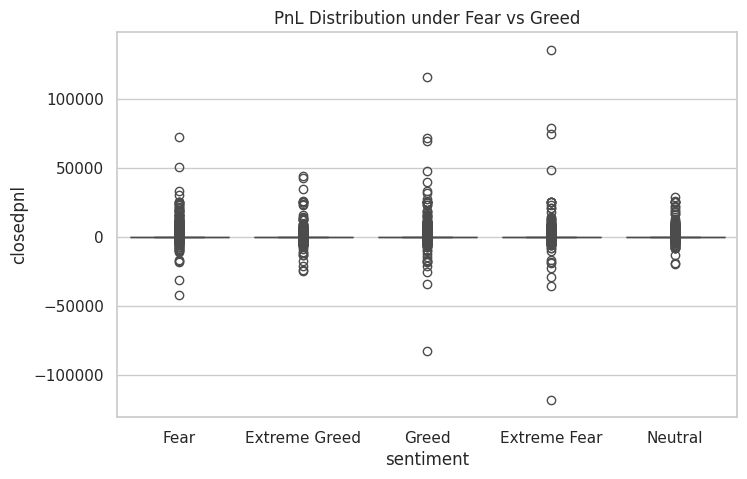

In [86]:
# ================================
# 10 VISUALIZATION – PnL vs Sentiment
# ================================
plt.figure(figsize=(8,5))
sns.boxplot(x='sentiment', y='closedpnl', data=trader_df)
plt.title("PnL Distribution under Fear vs Greed")
plt.savefig("outputs/pnl_distribution.png")
plt.show()


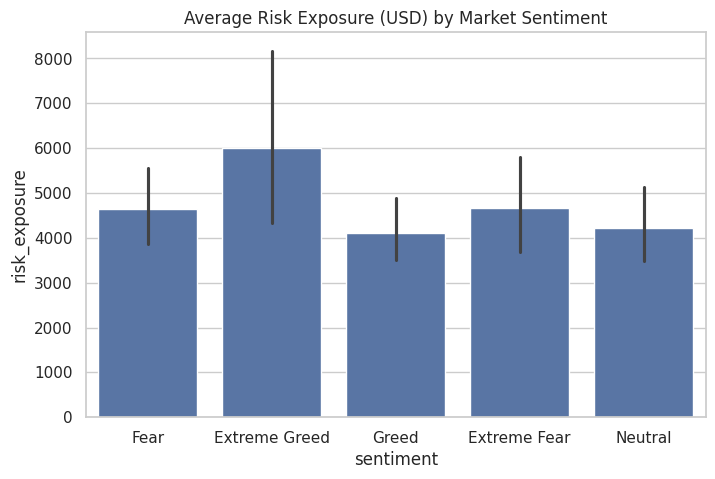

In [87]:
# ================================
# 1️1 VISUALIZATION – Risk Exposure
# ================================
plt.figure(figsize=(8,5))
sns.barplot(x='sentiment', y='risk_exposure', data=trader_df, estimator=np.mean)
plt.title("Average Risk Exposure (USD) by Market Sentiment")
plt.savefig("outputs/risk_by_sentiment.png")
plt.show()


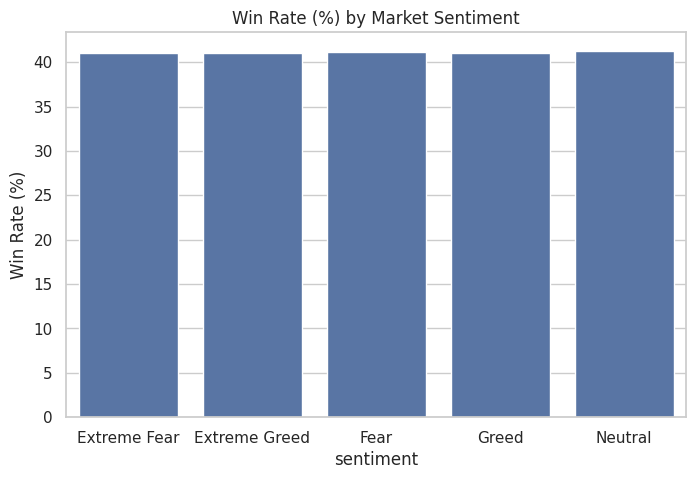

In [88]:
# ================================
# 1️2️ VISUALIZATION – Win Rate
# ================================
plt.figure(figsize=(8,5))
sns.barplot(x='sentiment', y='win_rate', data=summary)
plt.title("Win Rate (%) by Market Sentiment")
plt.ylabel("Win Rate (%)")
plt.savefig("outputs/winrate_by_sentiment.png")
plt.show()


In [89]:
# ================================
# 1️3️ FINAL INSIGHTS PRINT
# ================================
print("===== FINAL INSIGHTS =====")
print(summary)

===== FINAL INSIGHTS =====
       sentiment    avg_pnl  median_pnl     avg_risk  total_volume   win_rate
0   Extreme Fear  46.654680         0.0  4655.631679  2.335144e+08  41.067999
1  Extreme Greed  43.109818         0.0  6009.880943  1.492533e+08  41.076095
2           Fear  49.771294         0.0  4641.010151  3.421165e+08  41.133793
3          Greed  52.032654         0.0  4115.478067  2.825022e+08  41.073683
4        Neutral  48.804347         0.0  4221.942075  1.838010e+08  41.312778
